8/1/2019

I need to get accuracy values for the literal listener and pragmatic listener evaluation metrics for the part of my paper where I talk about how the accurcies don't really matter:

In [2]:
import sys
sys.path.append("..")

In [4]:
import caption_featurizers
import color_featurizers
from evaluation import delta_e_dist
from experiment import FeatureHandler
from models import LiteralListener, CaptionEncoder, LiteralSpeakerScorer, CaptionGenerator
from monroe_data import MonroeData, MonroeDataEntry, Color # for loading in training data

In [36]:
import numpy as np
import torch
from sklearn.metrics import classification_report, accuracy_score
from scipy.special import logsumexp

In [3]:
train_data = MonroeData("../data/csv/train_corpus_monroe.csv", "../data/entries/train_entries_monroe.pkl")
test_data = MonroeData("../data/csv/test_corpus_monroe.csv", "../data/entries/test_entries_monroe.pkl")

caption_phi = caption_featurizers.CaptionFeaturizer(tokenizer=caption_featurizers.EndingTokenizer)
color_phi_listener = color_featurizers.ColorFeaturizer(color_featurizers.color_phi_fourier, "rgb", normalized=True) # NOTE: RGB
color_phi_speaker = color_featurizers.ColorFeaturizer(color_featurizers.color_phi_fourier, "hsv", normalized=True) # NOTE: RGB

feature_handler_ll = FeatureHandler(train_data, test_data, caption_phi, color_phi_listener, randomized_colors=True)

def speaker_target(data_entry):
    _, caption_ids = caption_phi.to_string_features(data_entry.caption) # this probably works...
    target = caption_ids[1:]
    return target
feature_handler_pl = FeatureHandler(train_data, test_data, caption_phi, color_phi_speaker,
                                    target_fn=speaker_target, randomized_colors=False)

In [ ]:
# Let's do the literal listener first

In [5]:
model_ll = LiteralListener(CaptionEncoder)
model_ll.init_model(
            embed_dim=100,
            hidden_dim=100,
            vocab_size=feature_handler_ll.caption_featurizer.caption_indexer.size,
            color_dim=54)
model_ll.load_model("../model/literal_listener_5epoch_endings_tkn.params")

In [7]:
X_assess_ll = feature_handler_ll.test_features()
y_assess_ll = feature_handler_ll.test_targets()

In [12]:
scores_ll = model_ll.predict(X_assess_ll)

In [15]:
preds_ll = np.argmax(scores_ll, axis=1)

In [17]:
print(classification_report(preds_ll, y_assess_ll))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77      5270
           1       0.76      0.76      0.76      5209
           2       0.76      0.77      0.77      5180

    accuracy                           0.77     15659
   macro avg       0.77      0.77      0.77     15659
weighted avg       0.77      0.77      0.77     15659



In [48]:
sum(preds_ll == y_assess_ll)/len(y_assess_ll)

0.7653106839517211

In [ ]:
# Now let's do this for the Pragmatic Listener

In [6]:
model_pl = LiteralSpeakerScorer(CaptionGenerator)
model_pl.init_model(color_in_dim=54,
                    color_dim=100,
                    vocab_size=feature_handler_pl.caption_featurizer.caption_indexer.size,
                    embed_dim=100,
                    speaker_hidden_dim=100)
model_pl.load_model("../model/literal_speaker_30epochGLOVE.params")

In [18]:
X_assess_pl = feature_handler_pl.test_features()
y_assess_pl = feature_handler_pl.test_targets()

In [19]:
scores_pl = model_pl.predict(X_assess_pl)

In [28]:
scores_c_pl = speaker_predictions_to_scores(scores_pl, y_assess_pl)

In [29]:
preds_pl = np.argmax(scores_c_pl, axis=1)

In [35]:
sum(preds_pl == 0)/len(preds_pl)

0.7501756178555463

In [47]:
print(classification_report(np.zeros(len(preds_pl)), preds_pl))

              precision    recall  f1-score   support

         0.0       1.00      0.75      0.86     15659
         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         0

    accuracy                           0.75     15659
   macro avg       0.33      0.25      0.29     15659
weighted avg       1.00      0.75      0.86     15659



/Users/benjaminnewman/miniconda3/envs/listener-evaluation/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [27]:
def speaker_predictions_to_scores(results, targets):
    """Translate the the predicted probabilities for each
    token for each color into scores for each color
    
    Args:
        results: the raw list of list of tensors output by the model
        targets: the tokens in the gold caption.
        
    Returns:
        np.array of shape (len(targets),) containing scores for target color.
    """
    all_scores = []
    target_lens = np.array([len(target) for target in targets])
    for i, predictions in enumerate(results):

        scores = [0, 0, 0]
        for j, prediction in enumerate(predictions):
            scores[j] = np.sum(prediction[np.arange(target_lens[i]), targets[i]].numpy()) # end tokens are already cut off

        all_scores.append(scores)
    
    # now we can softmax these probabilities in log space
    all_scores = np.array(all_scores)
    all_scores_dist = (all_scores.T - logsumexp(all_scores, axis=1)).T
    # the target is at index 0
    return all_scores_dist

In [ ]:
# just out of curiousity... what happens if we feed in random sequences of tokens along with randomly 
# generated contexts?

In [114]:
class FakeMonroeData:
    """Class that has the minimal set of variables needed to run the predictions"""
    def __init__(self, caption, colors):
        self.caption = caption
        self.colors = colors
        self.target_idx = 0

In [115]:
import random
random.seed(142)
def gen_fake_data():
    rand_colors = []
    for _ in range(3):
        rand_color = [random.randint(0, 255) for _ in range(3)]
        rand_colors.append(Color(*rand_color, "rgb"))
    
    rand_tokens = ['<sos>']
    while True: # geometric distribution with hard tail
        rand_token = random.choice(list(feature_handler_ll.caption_featurizer.caption_indexer.word2idx.keys()))
        rand_tokens.append(rand_token)
        if random.random() < 0.2 or len(rand_tokens) > 10:
            break
    rand_tokens.append('<eos>')
    
    return FakeMonroeData(" ".join(rand_tokens), rand_colors)

In [116]:
fake_data = []
for _ in range(1000):
    fake_data.append(gen_fake_data())

In [99]:
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

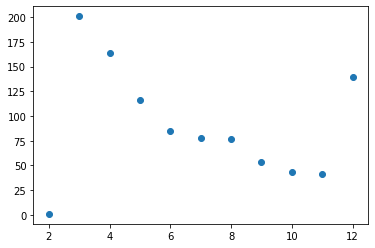

In [101]:
plt.scatter(*list(zip(*Counter([len(d.caption.split()) for d in fake_data]).items())))

<sos> cheeks almosy nor speak grass-like rosy blah ? cheeks <eos>


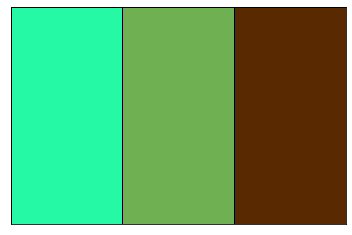

In [138]:
i = 4
train_data.display_custom_game(fake_data[i].colors, fake_data[i].caption)

In [118]:
feature_handler_ll_rand = FeatureHandler(train_data, fake_data, caption_phi, color_phi_listener, randomized_colors=True)

X_assess_ll_rand = feature_handler_ll_rand.test_features()
y_assess_ll_rand = feature_handler_ll_rand.test_targets()

In [119]:
scores_raw_ll_rand = model_ll.predict(X_assess_ll_rand)
scores_ll_rand = np.exp(scores_raw_ll_rand[np.arange(len(scores_raw_ll_rand)), y_assess_ll_rand])

In [120]:
scores_ll_rand[:10]

array([9.7728604e-01, 9.6860397e-01, 2.8813784e-07, 2.4888052e-01,
       2.6270071e-11, 1.8835228e-31, 9.5540136e-01, 1.6193444e-15,
       7.0511229e-02, 9.9990845e-01], dtype=float32)

{'bodies': [<matplotlib.collections.PolyCollection at 0x1c3c2597b8>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x1c3c25d400>,
 'cmins': <matplotlib.collections.LineCollection at 0x1c3c259a20>,
 'cbars': <matplotlib.collections.LineCollection at 0x1c3c259908>}

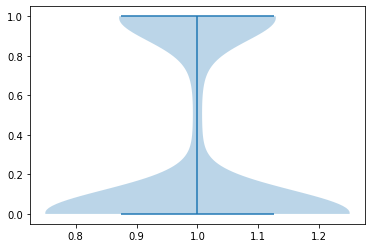

In [121]:
plt.violinplot(scores_ll_rand)

(array([316.,   0.,   0.,   0.,   0., 362.,   0.,   0.,   0., 322.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

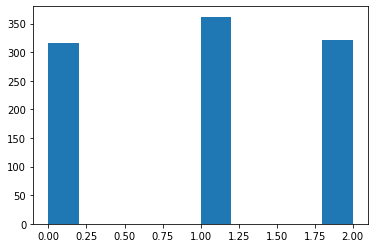

In [124]:
plt.hist(np.argmax(scores_raw_ll_rand, axis=1))

In [125]:
feature_handler_pl_rand = FeatureHandler(train_data, fake_data, caption_phi, color_phi_speaker,
                                    target_fn=speaker_target, randomized_colors=False)

In [126]:
X_assess_pl_rand = feature_handler_pl_rand.test_features()
y_assess_pl_rand = feature_handler_pl_rand.test_targets()

scores_pl_rand = model_pl.predict(X_assess_pl_rand)
scores_c_pl_rand = speaker_predictions_to_scores(scores_pl_rand, y_assess_pl_rand)

{'bodies': [<matplotlib.collections.PolyCollection at 0x1c3c68d710>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x1c3c68d630>,
 'cmins': <matplotlib.collections.LineCollection at 0x1c3c68d978>,
 'cbars': <matplotlib.collections.LineCollection at 0x1c3c68d780>}

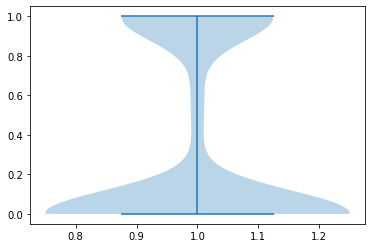

In [128]:
plt.violinplot(np.exp(scores_c_pl_rand[:, 0]))

{'bodies': [<matplotlib.collections.PolyCollection at 0x1c3adb9f98>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x1c3adb90b8>,
 'cmins': <matplotlib.collections.LineCollection at 0x1c3adb91d0>,
 'cbars': <matplotlib.collections.LineCollection at 0x1c3ab207b8>}

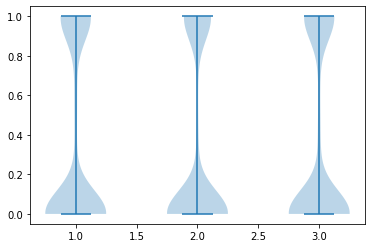

In [135]:
plt.violinplot(np.exp(scores_c_pl_rand))

In [136]:
np.exp(scores_c_pl_rand)[:10]

array([[5.8017915e-01, 1.8968105e-02, 4.0085253e-01],
       [1.1675007e-15, 1.0000000e+00, 0.0000000e+00],
       [4.1526216e-01, 1.8513106e-01, 3.9960670e-01],
       [3.7335354e-01, 5.0549334e-01, 1.2115098e-01],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [4.5185294e-07, 1.8336779e-14, 1.0000000e+00],
       [5.8413045e-14, 3.1834097e-12, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00]], dtype=float32)

In [130]:
scores_pl_rand_true = np.exp(scores_c_pl_rand[:, 0])

In [132]:
scores_pl_rand_true[:10]

array([5.8017915e-01, 1.1675007e-15, 4.1526216e-01, 3.7335354e-01,
       1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 4.5185294e-07,
       5.8413045e-14, 0.0000000e+00], dtype=float32)

(array([349.,   0.,   0.,   0.,   0., 313.,   0.,   0.,   0., 338.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

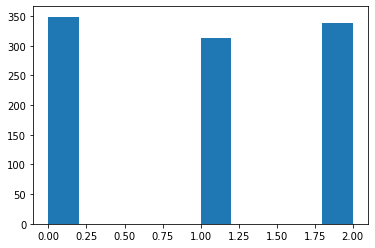

In [134]:
plt.hist(np.argmax(scores_c_pl_rand, axis=1))